In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import warnings
warnings.filterwarnings("ignore")

In [7]:
ori = np.load('../../OUTPUT/toyexample/origin_data_unnorm_toyexample.npy')
gen = np.load('../../OUTPUT/toyexample/generate_data_unnorm_toyexample.npy')

In [3]:
def split_to_chunks(data, seq_length):
    """
    data: np.ndarray, shape (M, C)
    return: np.ndarray, shape (N, seq_length, C)
    """
    M, C = data.shape
    num_chunks = M // seq_length
    trimmed = data[: num_chunks * seq_length]
    chunks = trimmed.reshape(num_chunks, seq_length, C)
    return chunks

In [4]:
def visualization_distribution(ori_data, generated_data):
    """PCA / tSNE / KDE visualization in a 3x3 grid:
       Col1: Original, Col2: Synthetic, Col3: Overlay (Original + Synthetic)
    """

    ori_data = np.asarray(ori_data)
    generated_data = np.asarray(generated_data)

    no, seq_len, dim = ori_data.shape

    # (no, seq_len): each sample -> mean over feature dim
    # 原来你的写法是循环拼接，这里等价向量化（更快、更简洁）
    prep_data = np.mean(ori_data, axis=2)        # (no, seq_len)
    prep_data_hat = np.mean(generated_data, axis=2)

    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    titles = ["Original", "Synthetic", "Overlay"]

    # ===================== Row 1: PCA =====================
    pca = PCA(n_components=2)
    pca.fit(prep_data)
    pca_results = pca.transform(prep_data)
    pca_hat_results = pca.transform(prep_data_hat)

    # Original
    axes[0, 0].scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.2, s=10)
    axes[0, 0].set_title(f"PCA | {titles[0]}")
    axes[0, 0].set_xlabel("x-pca")
    axes[0, 0].set_ylabel("y-pca")

    # Synthetic
    axes[0, 1].scatter(pca_hat_results[:, 0], pca_hat_results[:, 1], alpha=0.2, s=10)
    axes[0, 1].set_title(f"PCA | {titles[1]}")
    axes[0, 1].set_xlabel("x-pca")
    axes[0, 1].set_ylabel("y-pca")

    # Overlay
    axes[0, 2].scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.2, s=10, label="Original")
    axes[0, 2].scatter(pca_hat_results[:, 0], pca_hat_results[:, 1], alpha=0.2, s=10, label="Synthetic")
    axes[0, 2].set_title(f"PCA | {titles[2]}")
    axes[0, 2].set_xlabel("x-pca")
    axes[0, 2].set_ylabel("y-pca")
    axes[0, 2].legend(frameon=False)

    # ===================== Row 2: t-SNE =====================
    prep_data_final = np.concatenate((prep_data, prep_data_hat), axis=0)

    # sklearn 有的版本是 n_iter，有的版本是 max_iter；你原来用 n_iter，这里保持不动
    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(prep_data_final)

    tsne_ori = tsne_results[:no]
    tsne_hat = tsne_results[no:]

    # Original
    axes[1, 0].scatter(tsne_ori[:, 0], tsne_ori[:, 1], alpha=0.2, s=10)
    axes[1, 0].set_title(f"t-SNE | {titles[0]}")
    axes[1, 0].set_xlabel("x-tsne")
    axes[1, 0].set_ylabel("y-tsne")

    # Synthetic
    axes[1, 1].scatter(tsne_hat[:, 0], tsne_hat[:, 1], alpha=0.2, s=10)
    axes[1, 1].set_title(f"t-SNE | {titles[1]}")
    axes[1, 1].set_xlabel("x-tsne")
    axes[1, 1].set_ylabel("y-tsne")

    # Overlay
    axes[1, 2].scatter(tsne_ori[:, 0], tsne_ori[:, 1], alpha=0.2, s=10, label="Original")
    axes[1, 2].scatter(tsne_hat[:, 0], tsne_hat[:, 1], alpha=0.2, s=10, label="Synthetic")
    axes[1, 2].set_title(f"t-SNE | {titles[2]}")
    axes[1, 2].set_xlabel("x-tsne")
    axes[1, 2].set_ylabel("y-tsne")
    axes[1, 2].legend(frameon=False)

    # ===================== Row 3: KDE =====================
    flat_ori = prep_data.reshape(-1)
    flat_hat = prep_data_hat.reshape(-1)

    # Original
    sns.kdeplot(flat_ori, linewidth=3, ax=axes[2, 0])
    axes[2, 0].set_title(f"KDE | {titles[0]}")
    axes[2, 0].set_xlabel("Data Value")
    axes[2, 0].set_ylabel("Density")

    # Synthetic
    sns.kdeplot(flat_hat, linewidth=3, linestyle="--", ax=axes[2, 1])
    axes[2, 1].set_title(f"KDE | {titles[1]}")
    axes[2, 1].set_xlabel("Data Value")
    axes[2, 1].set_ylabel("Density")

    # Overlay
    sns.kdeplot(flat_ori, linewidth=3, ax=axes[2, 2], label="Original")
    sns.kdeplot(flat_hat, linewidth=3, linestyle="--", ax=axes[2, 2], label="Synthetic")
    axes[2, 2].set_title(f"KDE | {titles[2]}")
    axes[2, 2].set_xlabel("Data Value")
    axes[2, 2].set_ylabel("Density")
    axes[2, 2].legend(frameon=False)

    plt.tight_layout()
    plt.show()
    plt.close()


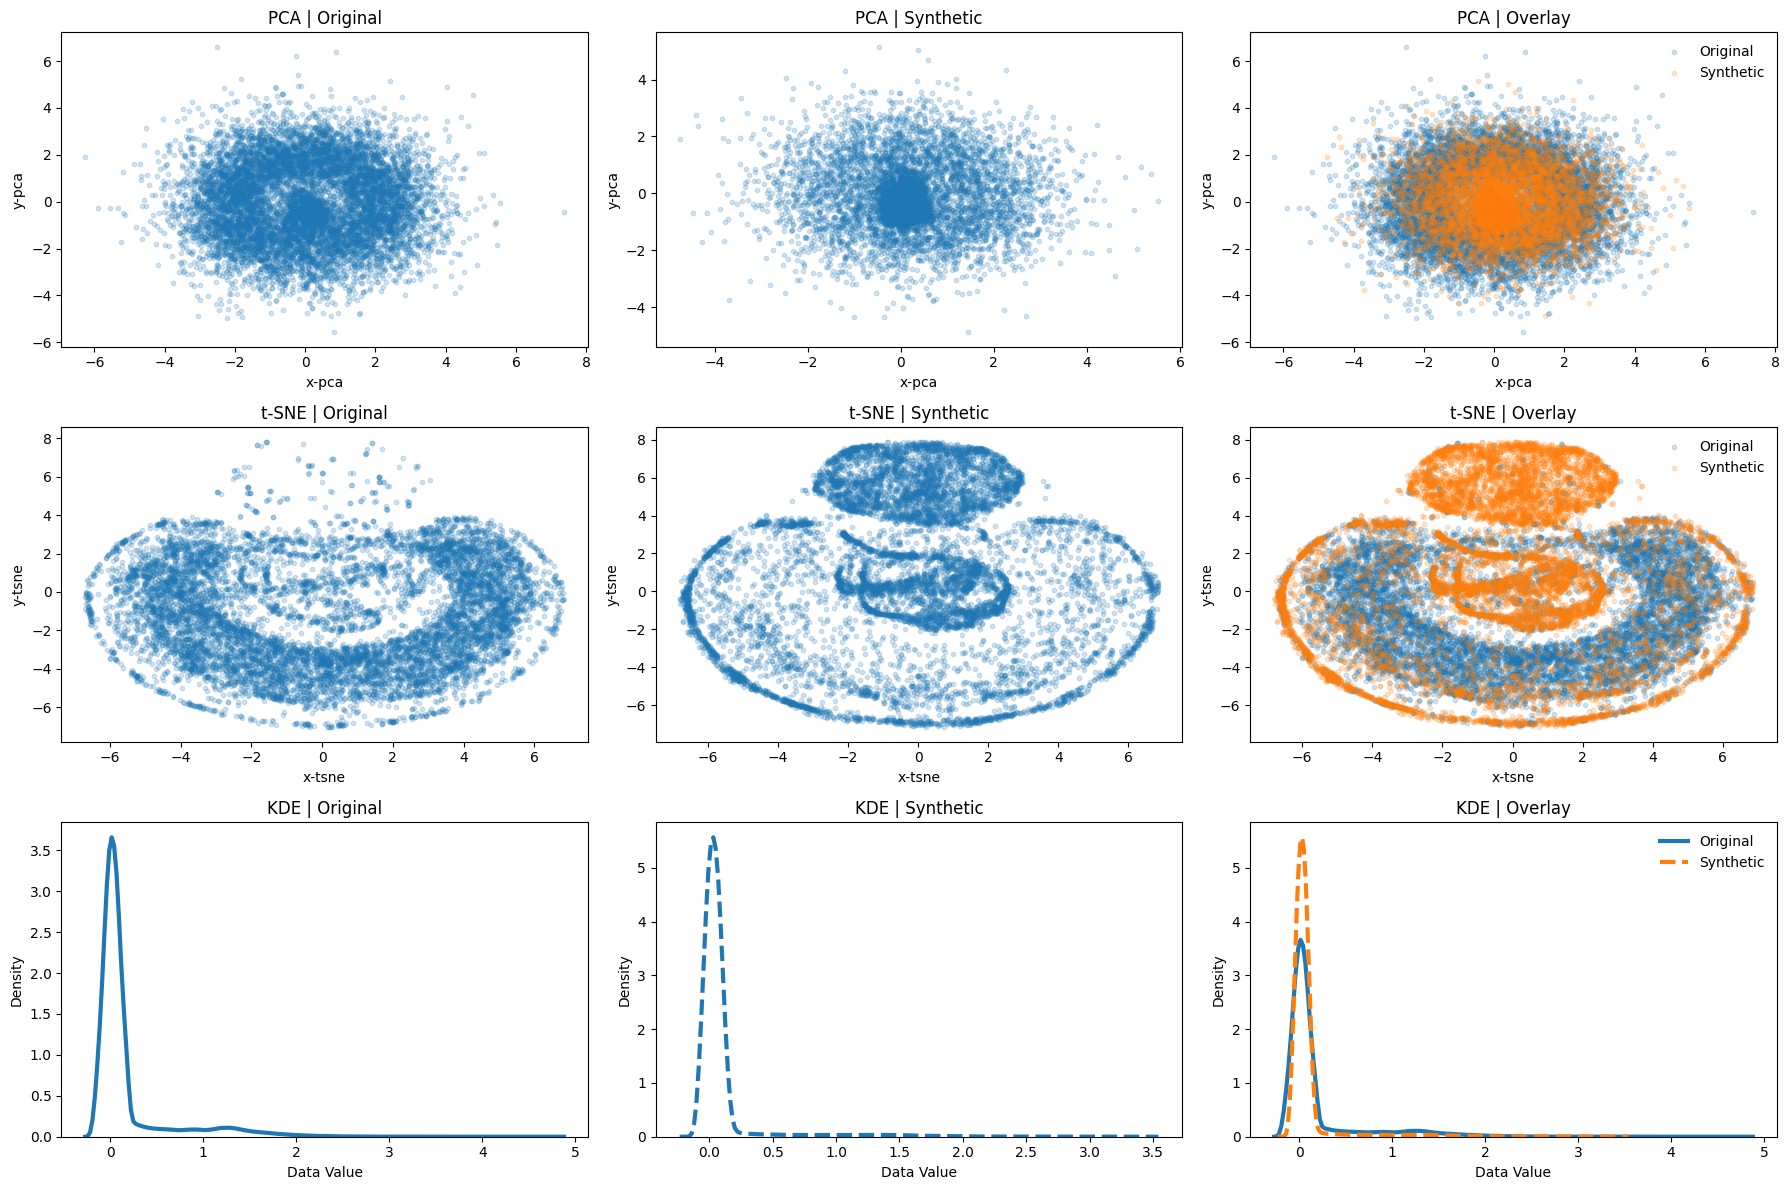

In [5]:
visualization_distribution(ori, gen)

In [3]:
def _local_maxima_above_thr(x1d: np.ndarray, thr: float) -> np.ndarray:
    x = x1d.astype(np.float32)
    L = x.size
    if L < 3:
        return np.array([], dtype=np.int32)
    mid = x[1:-1]
    left = x[:-2]
    right = x[2:]
    mask = (mid > float(thr)) & (mid > left) & (mid >= right)
    idx = np.flatnonzero(mask) + 1
    return idx.astype(np.int32)

def _nms_peaks(peaks: np.ndarray, x: np.ndarray, min_gap: int) -> np.ndarray:
    if peaks.size == 0:
        return peaks
    order = np.argsort(-x[peaks])  # desc by height
    chosen = []
    for j in order:
        t0 = int(peaks[j])
        if all(abs(t0 - int(tt)) >= int(min_gap) for tt in chosen):
            chosen.append(t0)
    chosen.sort()
    return np.asarray(chosen, dtype=np.int32)

def _extract_run_bounds(x: np.ndarray, t0: int, thr: float) -> tuple[int, int]:
    L = x.size
    l = t0
    while l - 1 >= 0 and x[l - 1] > float(thr):
        l -= 1
    r = t0
    while r + 1 < L and x[r + 1] > float(thr):
        r += 1
    return int(l), int(r)

def _roughness_score(seg: np.ndarray) -> float:
    seg = seg.astype(np.float32)
    if seg.size < 5:
        return 0.0
    peak = float(np.max(seg) + 1e-12)
    y = (seg / peak).astype(np.float32)
    d2 = y[2:] - 2.0*y[1:-1] + y[:-2]
    return float(np.mean(np.abs(d2)))

def _classify_shape_jitter(
    x: np.ndarray,
    l: int,
    r: int,
    jitter_thr: float = 0.06,
    skew_log_thr: float = 0.55,
) -> int:
    seg = x[l:r+1]
    if seg.size == 0:
        return 0

    # 1) skew first
    j = int(np.argmax(seg))
    t_peak = l + j
    left_len = max(0, t_peak - l)
    right_len = max(0, r - t_peak)
    skew_ratio = (right_len + 1.0) / (left_len + 1.0)
    skew_score = abs(float(np.log(skew_ratio)))
    if skew_score >= float(skew_log_thr):
        return 2

    # 2) jitter second
    rs = _roughness_score(seg.astype(np.float32))
    if rs >= float(jitter_thr):
        return 1

    return 0

def extract_events_stats(
    X: np.ndarray,
    thr: float = 1.0,
    min_gap: int = 15,
    class_width_thr: int = 11,
    class_skew_log_thr: float = 0.6
):
    """
    Output events[i] list of dicts:
      {
        "t0": int,           seed peak index
        "amp_raw": float,    raw peak at seed t0
        "shape": int,        0/1/2 using new classifier
        "l","r": int         threshold run bounds
      }
    """
    X = np.asarray(X, dtype=np.float32)
    x = X[:, :, 0] if X.ndim == 3 else X
    N, L = x.shape

    out = []
    for i in range(N):
        xi = x[i]
        peaks = _local_maxima_above_thr(xi, thr=thr)
        peaks = _nms_peaks(peaks, xi, min_gap=int(min_gap))

        ev_i = []
        for t0 in peaks:
            t0 = int(t0)
            l, r = _extract_run_bounds(xi, t0, thr=thr)
            shape = _classify_shape_jitter(
                xi, l, r,
                jitter_thr=0.155,
                skew_log_thr=0.45,
            )
            ev_i.append({
                "t0": t0,
                "amp_raw": float(xi[t0]),
                "shape": int(shape),
                "l": int(l),
                "r": int(r),
            })
        out.append(ev_i)

    return out

def summarize_events(events, n_shapes: int = 3):
    K_per_sample = np.array([len(ei) for ei in events], dtype=np.int32)
    t0s, amps, shapes = [], [], []
    for ei in events:
        for e in ei:
            t0s.append(int(e["t0"]))
            amps.append(float(e["amp_raw"]))
            shapes.append(int(e["shape"]))
    if len(t0s) == 0:
        return K_per_sample, np.array([], np.int32), np.array([], np.float32), np.zeros(n_shapes, np.int64)
    t0s = np.asarray(t0s, dtype=np.int32)
    amps = np.asarray(amps, dtype=np.float32)
    shapes = np.asarray(shapes, dtype=np.int32)
    shape_counts = np.bincount(shapes, minlength=n_shapes).astype(np.int64)
    return K_per_sample, t0s, amps, shape_counts

In [4]:
def plot_random_5(X, seed=0):
    X = np.asarray(X)
    X2 = X[:, :, 0] if X.ndim == 3 else X  # (N,L)
    N, L = X2.shape

    rng = np.random.default_rng(seed)
    idx = rng.choice(N, size=min(5, N), replace=False)

    t = np.arange(L)
    plt.figure(figsize=(10, 4))
    for i in idx:
        plt.plot(t, X2[i], alpha=0.9, label=f"idx={int(i)}")
    plt.title("Random 5 samples from X")
    plt.xlabel("Time index")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

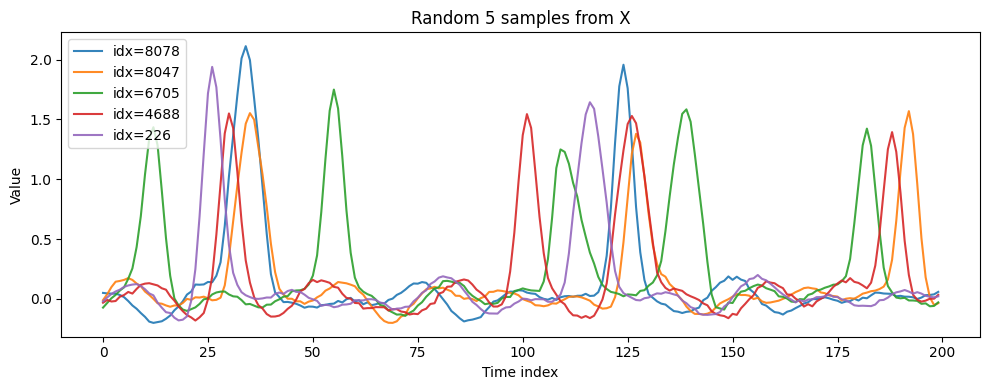

In [5]:
plot_random_5(ori,seed=5)

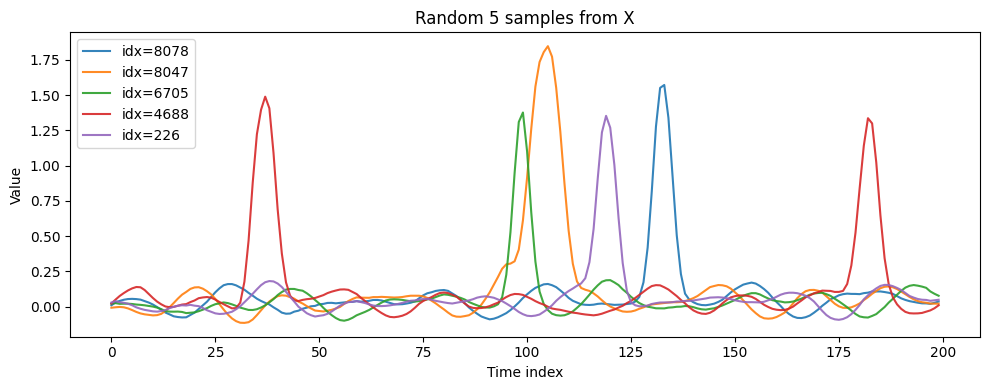

In [6]:
plot_random_5(gen,seed=5)

In [10]:
orievent = extract_events_stats(ori, thr=1.0, min_gap=15)
genevent = extract_events_stats(gen, thr=1.0, min_gap=15)

shapename = {0: 'smooth_gaussian', 1: 'jittered_peak', 2: 'skewed_gaussian'}

In [11]:
def plot_and_summarize_4_distributions_v2(
    X,
    events,
    L=None,
    shape_names=None,
    bins_amp=30,
    thr=None,               # 可选：如果你想在幅值统计里报告 >thr 的比例
):
    """
    基于 events（extract_events_stats 输出）做四个分布：
      (1) location: 事件段内最大值位置 t_peak
      (2) count:    每条样本事件数 K_hat
      (3) amplitude:事件段内最大值 amp_peak
      (4) shape:    事件 shape 标签

    X: (N,L,1) or (N,L)
    events: list length N, each is list of dicts with keys at least:
            {"t0","l","r","shape"}; "t0" 可能是 seed peak，不一定等于段内最大值位置
    """
    if shape_names is None:
        shape_names = {0: "shape0", 1: "shape1", 2: "shape2"}

    X = np.asarray(X, dtype=np.float32)
    x = X[:, :, 0] if X.ndim == 3 else X
    N, Lx = x.shape
    if L is None:
        L = Lx
    else:
        L = int(L)

    # -----------------------------
    # 1) 聚合成数组
    # -----------------------------
    K_hat = np.array([len(ei) for ei in events], dtype=np.int32)

    t_peaks = []
    amp_peaks = []
    amp_at_seed = []
    shapes = []

    for i, ei in enumerate(events):
        xi = x[i]
        for e in ei:
            l = int(e["l"])
            r = int(e["r"])
            l = max(0, min(l, Lx - 1))
            r = max(0, min(r, Lx - 1))
            if r < l:
                l, r = r, l

            seg = xi[l:r+1]
            if seg.size == 0:
                continue

            j = int(np.argmax(seg))
            t_peak = l + j
            a_peak = float(seg[j])

            t_peaks.append(int(t_peak))
            amp_peaks.append(float(a_peak))
            shapes.append(int(e["shape"]))

            # 额外：seed 位置的值（便于 debug：seed peak vs true peak）
            t0_seed = int(e.get("t0", t_peak))
            t0_seed = max(0, min(t0_seed, Lx - 1))
            amp_at_seed.append(float(xi[t0_seed]))

    t_peaks = np.asarray(t_peaks, dtype=np.int32)
    amp_peaks = np.asarray(amp_peaks, dtype=np.float32)
    amp_at_seed = np.asarray(amp_at_seed, dtype=np.float32)
    shapes = np.asarray(shapes, dtype=np.int32)

    total_events = int(t_peaks.size)

    # -----------------------------
    # 2) 打印统计分析
    # -----------------------------
    print("===== 4 Distributions (events-based, v2) =====")
    print(f"N_samples = {N}")
    print(f"Total events = {total_events}")
    print()

    # (2) 数量 K_hat
    K_max = int(K_hat.max()) if N > 0 else 0
    K_counts = np.bincount(K_hat, minlength=K_max + 1)
    print("== (2) Count per sample (K_hat) ==")
    print(f"mean={K_hat.mean():.4f}, std={K_hat.std():.4f}, min={int(K_hat.min())}, max={int(K_hat.max())}")
    for k, c in enumerate(K_counts):
        print(f"  K_hat={k}: count={int(c)}, ratio={float(c)/float(N):.4f}")
    print()

    # (1) 位置 t_peak
    print("== (1) Location (t_peak: argmax within [l,r]) ==")
    if total_events == 0:
        print("  No events.")
    else:
        loc_counts = np.bincount(t_peaks, minlength=L)
        top = np.argsort(-loc_counts)[:10]
        print("  Top-10 locations (t_peak: count, ratio among events):")
        for tt in top:
            c = int(loc_counts[tt])
            if c == 0:
                break
            print(f"    t={int(tt)}: {c}, {c/total_events:.4f}")
    print()

    # (3) 幅值 amp_peaks
    print("== (3) Amplitude (peak=max over [l,r]) ==")
    if total_events == 0:
        print("  No events.")
    else:
        q = np.percentile(amp_peaks, [0, 1, 5, 25, 50, 75, 95, 99, 100])
        print(f"  mean={amp_peaks.mean():.4f}, std={amp_peaks.std():.4f}, min={amp_peaks.min():.4f}, max={amp_peaks.max():.4f}")
        print("  percentiles:")
        print(f"    p0={q[0]:.4f}, p1={q[1]:.4f}, p5={q[2]:.4f}, p25={q[3]:.4f}, p50={q[4]:.4f}, "
              f"p75={q[5]:.4f}, p95={q[6]:.4f}, p99={q[7]:.4f}, p100={q[8]:.4f}")

        if thr is not None:
            thr = float(thr)
            frac = float(np.mean(amp_peaks > thr))
            print(f"  fraction(amp_peak > {thr:.3f}) = {frac:.4f}")

        # debug: seed vs segment-argmax
        delta = amp_peaks - amp_at_seed
        print(f"  seed_vs_peak: mean(peak-seed)={float(delta.mean()):.6f}, p95={float(np.percentile(delta,95)):.6f}")
    print()

    # (4) 形状 shapes
    print("== (4) Shape ==")
    if total_events == 0:
        print("  No events.")
    else:
        n_shapes = max(3, int(shapes.max()) + 1)
        sc = np.bincount(shapes, minlength=n_shapes)
        for s in range(n_shapes):
            name = shape_names.get(s, f"shape{s}")
            c = int(sc[s])
            print(f"  shape={s} ({name}): count={c}, ratio={c/total_events:.4f}")
    print("================================================")

    # -----------------------------
    # 3) 画四张分布图
    # -----------------------------
    # (1) location
    plt.figure(figsize=(10, 3.6))
    if total_events == 0:
        plt.title("Location distribution (no events)")
    else:
        loc_counts = np.bincount(t_peaks, minlength=L)
        plt.bar(np.arange(L), loc_counts)
        plt.title("Location distribution of events (t_peak)")
        plt.xlabel("Time index")
        plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # (2) K distribution
    plt.figure(figsize=(7, 3.6))
    plt.bar(np.arange(K_counts.size), K_counts)
    plt.title("Count distribution per sample (K_hat)")
    plt.xlabel("K_hat (#events)")
    plt.ylabel("Number of samples")
    plt.tight_layout()
    plt.show()

    # (3) amplitude
    plt.figure(figsize=(7, 3.6))
    if total_events == 0:
        plt.title("Amplitude distribution (no events)")
    else:
        plt.hist(amp_peaks, bins=int(bins_amp))
        plt.title("Amplitude distribution (amp_peak = max over [l,r])")
        plt.xlabel("Amplitude")
        plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # (4) shape
    plt.figure(figsize=(7, 3.6))
    if total_events == 0:
        plt.title("Shape distribution (no events)")
    else:
        n_shapes = max(3, int(shapes.max()) + 1)
        sc = np.bincount(shapes, minlength=n_shapes)
        xs = np.arange(n_shapes)
        labels = [shape_names.get(i, f"shape{i}") for i in xs]
        plt.bar(xs, sc)
        plt.xticks(xs, labels, rotation=15)
        plt.title("Shape distribution (pred)")
        plt.xlabel("Shape type")
        plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    return {
        "K_hat": K_hat,
        "t_peaks": t_peaks,
        "amp_peaks": amp_peaks,
        "amp_at_seed": amp_at_seed,
        "shapes": shapes,
    }

===== 4 Distributions (events-based, v2) =====
N_samples = 10000
Total events = 29138

== (2) Count per sample (K_hat) ==
mean=2.9138, std=1.1507, min=0, max=6
  K_hat=0: count=157, ratio=0.0157
  K_hat=1: count=989, ratio=0.0989
  K_hat=2: count=2424, ratio=0.2424
  K_hat=3: count=3144, ratio=0.3144
  K_hat=4: count=2592, ratio=0.2592
  K_hat=5: count=663, ratio=0.0663
  K_hat=6: count=31, ratio=0.0031

== (1) Location (t_peak: argmax within [l,r]) ==
  Top-10 locations (t_peak: count, ratio among events):
    t=36: 410, 0.0141
    t=185: 396, 0.0136
    t=37: 394, 0.0135
    t=34: 392, 0.0135
    t=183: 389, 0.0134
    t=116: 389, 0.0134
    t=184: 385, 0.0132
    t=114: 380, 0.0130
    t=113: 376, 0.0129
    t=35: 374, 0.0128

== (3) Amplitude (peak=max over [l,r]) ==
  mean=1.6632, std=0.3790, min=1.1000, max=4.8097
  percentiles:
    p0=1.1000, p1=1.1680, p5=1.2346, p25=1.3743, p50=1.5722, p75=1.8626, p95=2.3939, p99=2.8717, p100=4.8097
  fraction(amp_peak > 1.000) = 1.0000
  seed

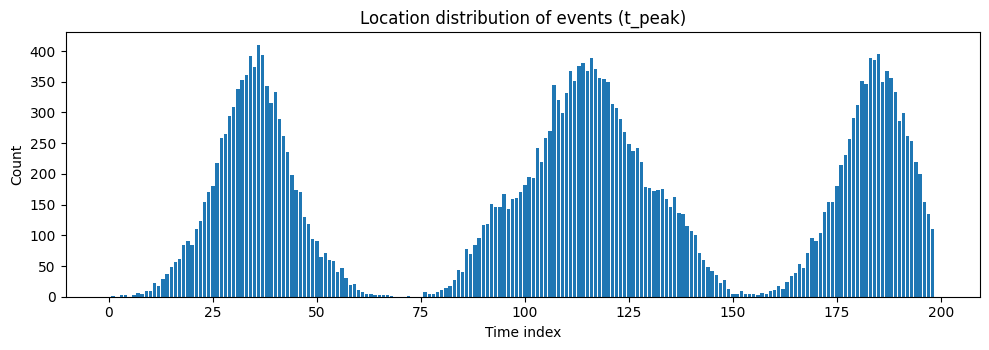

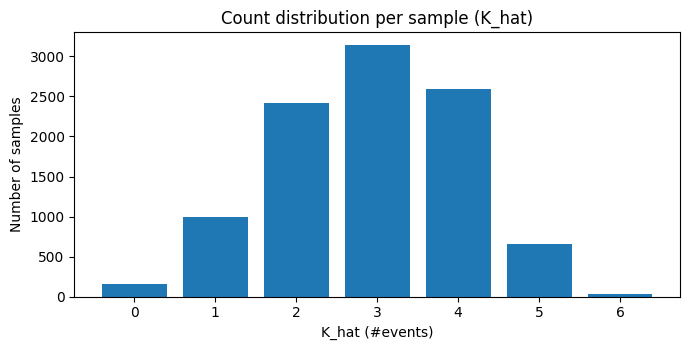

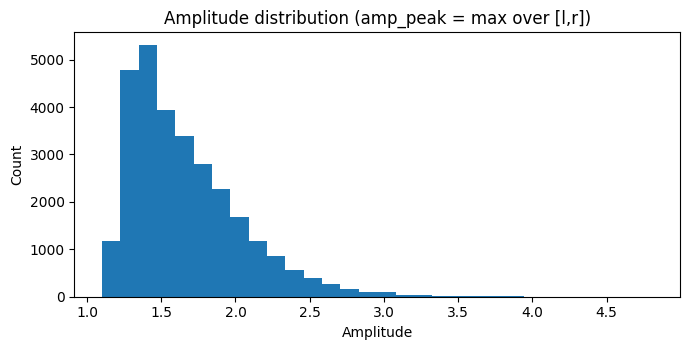

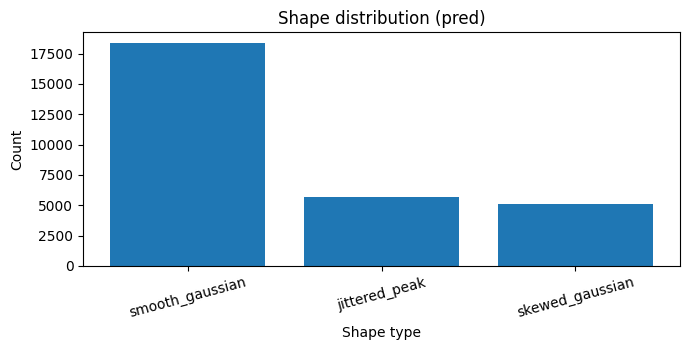

In [12]:
out = plot_and_summarize_4_distributions_v2(
    ori, orievent,
    L=200,
    shape_names=shapename,
    bins_amp=30,
    thr=1.0,
)

===== 4 Distributions (events-based, v2) =====
N_samples = 10000
Total events = 10119

== (2) Count per sample (K_hat) ==
mean=1.0119, std=0.9249, min=0, max=5
  K_hat=0: count=3463, ratio=0.3463
  K_hat=1: count=3635, ratio=0.3635
  K_hat=2: count=2293, ratio=0.2293
  K_hat=3: count=542, ratio=0.0542
  K_hat=4: count=63, ratio=0.0063
  K_hat=5: count=4, ratio=0.0004

== (1) Location (t_peak: argmax within [l,r]) ==
  Top-10 locations (t_peak: count, ratio among events):
    t=115: 197, 0.0195
    t=112: 195, 0.0193
    t=184: 193, 0.0191
    t=111: 191, 0.0189
    t=110: 186, 0.0184
    t=185: 181, 0.0179
    t=116: 176, 0.0174
    t=114: 176, 0.0174
    t=182: 169, 0.0167
    t=186: 167, 0.0165

== (3) Amplitude (peak=max over [l,r]) ==
  mean=1.6221, std=0.3838, min=1.0001, max=3.4996
  percentiles:
    p0=1.0001, p1=1.0215, p5=1.1164, p25=1.3565, p50=1.5577, p75=1.8050, p95=2.3531, p99=2.8762, p100=3.4996
  fraction(amp_peak > 1.000) = 1.0000
  seed_vs_peak: mean(peak-seed)=0.00000

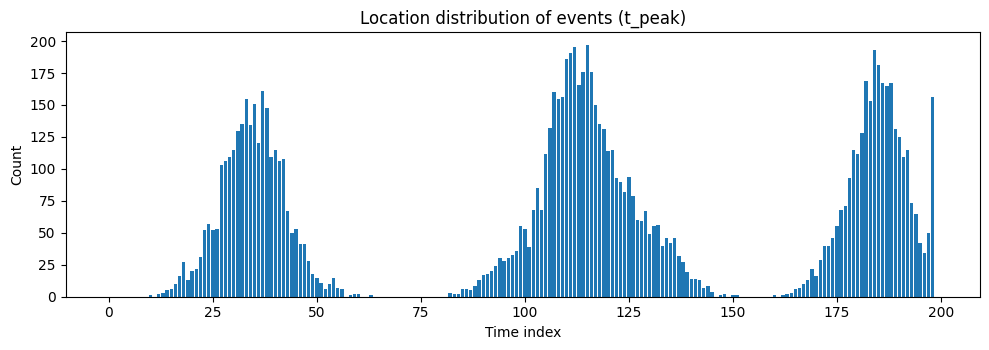

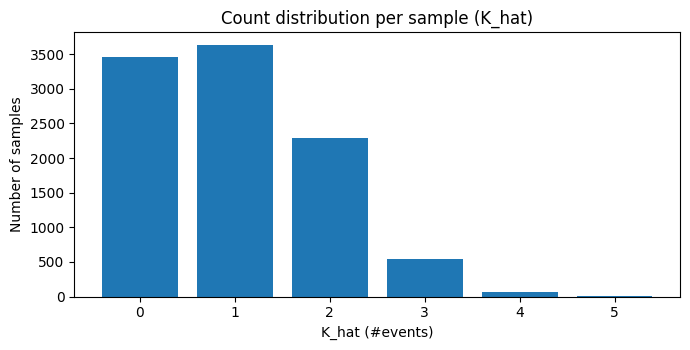

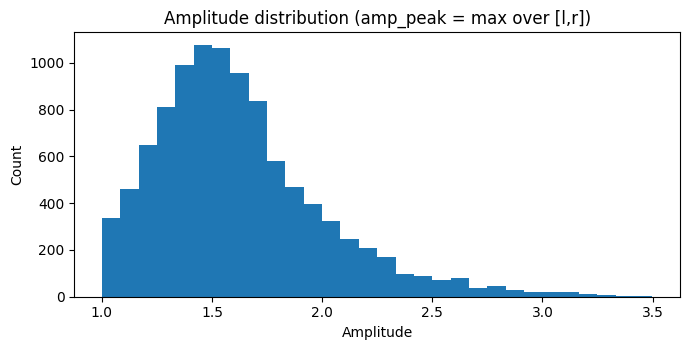

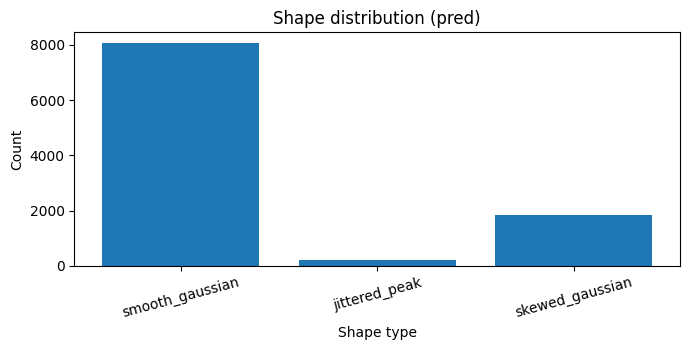

In [13]:
out = plot_and_summarize_4_distributions_v2(
    gen, genevent,
    L=200,
    shape_names=shapename,
    bins_amp=30,
    thr=1.0,
)

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def _aggregate_from_events(X, events, L=None):
    """
    X: (N,L,1) or (N,L)
    events: list length N, each element is list of dicts with keys: l,r,shape
    returns:
      K_hat: (N,)
      t_peaks: (E,)
      amp_peaks: (E,)
      shapes: (E,)
      Lx: int
    """
    X = np.asarray(X, dtype=np.float32)
    x = X[:, :, 0] if X.ndim == 3 else X
    N, Lx = x.shape
    if L is None:
        L = Lx
    else:
        L = int(L)

    K_hat = np.array([len(ei) for ei in events], dtype=np.int32)

    t_peaks, amp_peaks, shapes = [], [], []
    for i, ei in enumerate(events):
        xi = x[i]
        for e in ei:
            l = int(e["l"]); r = int(e["r"])
            l = max(0, min(l, Lx - 1))
            r = max(0, min(r, Lx - 1))
            if r < l:
                l, r = r, l
            seg = xi[l:r+1]
            if seg.size == 0:
                continue
            j = int(np.argmax(seg))
            t_peaks.append(l + j)
            amp_peaks.append(float(seg[j]))
            shapes.append(int(e.get("shape", -1)))

    t_peaks = np.asarray(t_peaks, dtype=np.int32)
    amp_peaks = np.asarray(amp_peaks, dtype=np.float32)
    shapes = np.asarray(shapes, dtype=np.int32)

    return K_hat, t_peaks, amp_peaks, shapes, L


def _print_stats(tag, K_hat, t_peaks, amp_peaks, shapes, L, shape_names):
    N = K_hat.size
    E = int(t_peaks.size)
    print(f"===== {tag} (events-based) =====")
    print(f"N_samples = {N}")
    print(f"Total events = {E}")

    # (2) K
    K_max = int(K_hat.max()) if N > 0 else 0
    K_counts = np.bincount(K_hat, minlength=K_max + 1)
    print("\n== (2) Count per sample (K_hat) ==")
    print(f"mean={K_hat.mean():.4f}, std={K_hat.std():.4f}, min={int(K_hat.min())}, max={int(K_hat.max())}")
    for k, c in enumerate(K_counts):
        print(f"  K_hat={k}: count={int(c)}, ratio={float(c)/float(N):.4f}")

    # (1) Location
    print("\n== (1) Location (t_peak) ==")
    if E == 0:
        print("  No events.")
    else:
        loc_counts = np.bincount(t_peaks, minlength=L)
        top = np.argsort(-loc_counts)[:10]
        print("  Top-10 locations (t_peak: count, ratio among events):")
        for tt in top:
            c = int(loc_counts[tt])
            if c == 0:
                break
            print(f"    t={int(tt)}: {c}, {c/float(E):.4f}")

    # (3) Amplitude
    print("\n== (3) Amplitude (peak=max over [l,r]) ==")
    if E == 0:
        print("  No events.")
    else:
        q = np.percentile(amp_peaks, [0, 1, 5, 25, 50, 75, 95, 99, 100])
        print(f"  mean={amp_peaks.mean():.4f}, std={amp_peaks.std():.4f}, "
              f"min={amp_peaks.min():.4f}, max={amp_peaks.max():.4f}")
        print("  percentiles:")
        print(f"    p0={q[0]:.4f}, p1={q[1]:.4f}, p5={q[2]:.4f}, p25={q[3]:.4f}, p50={q[4]:.4f}, "
              f"p75={q[5]:.4f}, p95={q[6]:.4f}, p99={q[7]:.4f}, p100={q[8]:.4f}")

    # (4) Shape
    print("\n== (4) Shape ==")
    if E == 0 or shapes.size == 0:
        print("  No events.")
    else:
        valid = shapes[shapes >= 0]
        n_shapes = max(3, int(valid.max()) + 1) if valid.size > 0 else 3
        sc = np.bincount(valid, minlength=n_shapes)
        for s in range(n_shapes):
            name = shape_names.get(s, str(s))
            c = int(sc[s])
            print(f"  shape={s} ({name}): count={c}, ratio={c/float(valid.size):.4f}")

    print("=================================\n")


def plot_and_summarize_4_distributions_compare(
    X_ori, events_ori,
    X_gen, events_gen,
    L=None,
    shape_names=None,
    bins_amp=30,
    show_density=False
):
    """
    将 ori vs gen 的四个分布画在同一个 figure（4行1列）里对比：
      (1) Location  (t_peak)
      (2) Count K_hat
      (3) Amplitude (event peak)
      (4) Shape

    需要你提前对 ori/gen 分别跑过 extract_events_stats 得到 events_ori/events_gen。
    """
    if shape_names is None:
        shape_names = {0: "smooth_gaussian", 1: "jittered_peak", 2: "skewed_gaussian"}

    # aggregate
    K_o, t_o, a_o, s_o, Lx = _aggregate_from_events(X_ori, events_ori, L=L)
    K_g, t_g, a_g, s_g, _  = _aggregate_from_events(X_gen, events_gen, L=Lx)

    # print stats
    _print_stats("ORI", K_o, t_o, a_o, s_o, Lx, shape_names)
    _print_stats("GEN", K_g, t_g, a_g, s_g, Lx, shape_names)

    # build counts for plots
    loc_o = np.bincount(t_o, minlength=Lx) if t_o.size > 0 else np.zeros(Lx, dtype=np.int64)
    loc_g = np.bincount(t_g, minlength=Lx) if t_g.size > 0 else np.zeros(Lx, dtype=np.int64)

    Kmax = int(max(K_o.max(), K_g.max()))
    Kc_o = np.bincount(K_o, minlength=Kmax+1)
    Kc_g = np.bincount(K_g, minlength=Kmax+1)

    valid_o = s_o[s_o >= 0]
    valid_g = s_g[s_g >= 0]
    n_shapes = max(3,
                   (int(valid_o.max())+1 if valid_o.size else 3),
                   (int(valid_g.max())+1 if valid_g.size else 3))
    Sc_o = np.bincount(valid_o, minlength=n_shapes) if valid_o.size else np.zeros(n_shapes, dtype=np.int64)
    Sc_g = np.bincount(valid_g, minlength=n_shapes) if valid_g.size else np.zeros(n_shapes, dtype=np.int64)

    # -----------------------------
    # plots (one figure, 4 rows)
    # -----------------------------
    fig, axes = plt.subplots(4, 1, figsize=(11, 12))

    # (1) Location: overlay lines
    ax = axes[0]
    ax.plot(np.arange(Lx), loc_o, label="ORI")
    ax.plot(np.arange(Lx), loc_g, label="GEN")
    ax.set_title("Location distribution (t_peak)")
    ax.set_xlabel("Time index")
    ax.set_ylabel("Count")
    ax.legend()

    # (2) Count per sample: grouped bars
    ax = axes[1]
    xs = np.arange(Kmax + 1)
    w = 0.40
    ax.bar(xs - w/2, Kc_o, width=w, label="ORI")
    ax.bar(xs + w/2, Kc_g, width=w, label="GEN")
    ax.set_title("Count distribution per sample (K_hat)")
    ax.set_xlabel("K_hat")
    ax.set_ylabel("Number of samples")
    ax.legend()

    # (3) Amplitude: overlay hist
    ax = axes[2]
    if a_o.size > 0:
        ax.hist(a_o, bins=int(bins_amp), alpha=0.6, density=bool(show_density), label="ORI")
    if a_g.size > 0:
        ax.hist(a_g, bins=int(bins_amp), alpha=0.6, density=bool(show_density), label="GEN")
    ax.set_title("Amplitude distribution (event peak)")
    ax.set_xlabel("Amplitude")
    ax.set_ylabel("Density" if show_density else "Count")
    ax.legend()

    # (4) Shape: grouped bars
    ax = axes[3]
    xs = np.arange(n_shapes)
    w = 0.40
    ax.bar(xs - w/2, Sc_o, width=w, label="ORI")
    ax.bar(xs + w/2, Sc_g, width=w, label="GEN")
    labels = [shape_names.get(i, str(i)) for i in xs]
    ax.set_xticks(xs)
    ax.set_xticklabels(labels, rotation=15)
    ax.set_title("Shape distribution")
    ax.set_xlabel("Shape type")
    ax.set_ylabel("Count")
    ax.legend()

    plt.tight_layout()
    plt.show()

    return {
        "ori": {"K_hat": K_o, "t_peaks": t_o, "amp_peaks": a_o, "shapes": s_o},
        "gen": {"K_hat": K_g, "t_peaks": t_g, "amp_peaks": a_g, "shapes": s_g},
        "L": Lx,
    }


===== ORI (events-based) =====
N_samples = 10000
Total events = 29138

== (2) Count per sample (K_hat) ==
mean=2.9138, std=1.1507, min=0, max=6
  K_hat=0: count=157, ratio=0.0157
  K_hat=1: count=989, ratio=0.0989
  K_hat=2: count=2424, ratio=0.2424
  K_hat=3: count=3144, ratio=0.3144
  K_hat=4: count=2592, ratio=0.2592
  K_hat=5: count=663, ratio=0.0663
  K_hat=6: count=31, ratio=0.0031

== (1) Location (t_peak) ==
  Top-10 locations (t_peak: count, ratio among events):
    t=36: 410, 0.0141
    t=185: 396, 0.0136
    t=37: 394, 0.0135
    t=34: 392, 0.0135
    t=183: 389, 0.0134
    t=116: 389, 0.0134
    t=184: 385, 0.0132
    t=114: 380, 0.0130
    t=113: 376, 0.0129
    t=35: 374, 0.0128

== (3) Amplitude (peak=max over [l,r]) ==
  mean=1.6632, std=0.3790, min=1.1000, max=4.8097
  percentiles:
    p0=1.1000, p1=1.1680, p5=1.2346, p25=1.3743, p50=1.5722, p75=1.8626, p95=2.3939, p99=2.8717, p100=4.8097

== (4) Shape ==
  shape=0 (smooth_gaussian): count=18343, ratio=0.6295
  shape=1

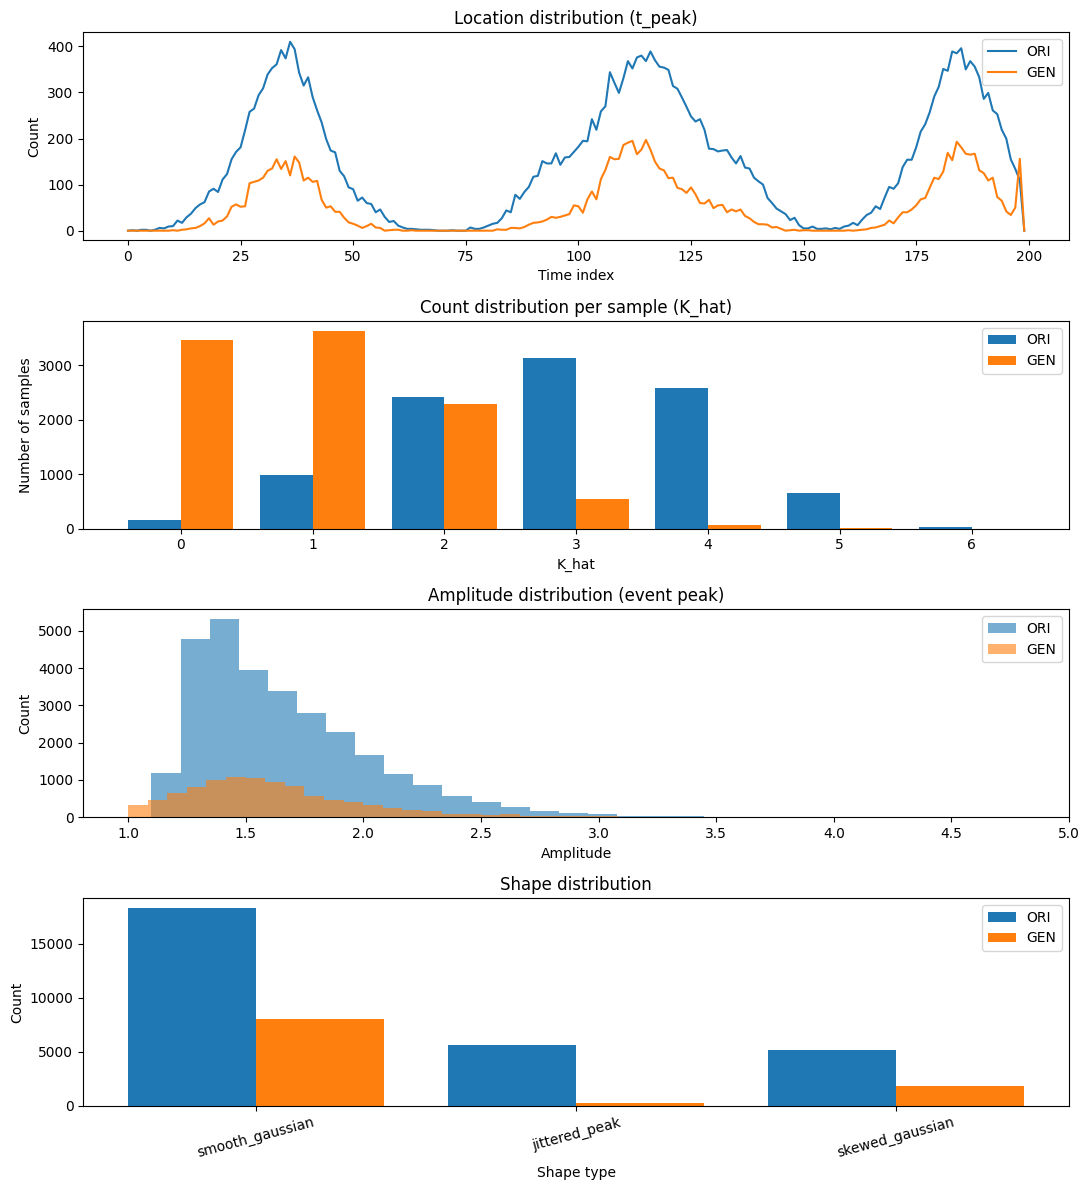

In [15]:
out = plot_and_summarize_4_distributions_compare(
    ori, orievent,
    gen, genevent,
    bins_amp=30,
    show_density=False
)

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- small utilities ----------
def _safe_prob(counts, eps=1e-12):
    counts = np.asarray(counts, dtype=np.float64)
    s = counts.sum()
    return (counts + eps) / (s + eps * counts.size)

def _js_divergence(p, q, eps=1e-12):
    p = np.asarray(p, dtype=np.float64); q = np.asarray(q, dtype=np.float64)
    p = _safe_prob(p, eps); q = _safe_prob(q, eps)
    m = 0.5 * (p + q)
    kl_pm = np.sum(p * (np.log(p) - np.log(m)))
    kl_qm = np.sum(q * (np.log(q) - np.log(m)))
    return 0.5 * (kl_pm + kl_qm)

def _entropy(p, eps=1e-12):
    p = _safe_prob(p, eps)
    return -np.sum(p * np.log(p))

def _aggregate_for_dashboard(X, events, L=None, n_shapes=3):
    X = np.asarray(X, dtype=np.float32)
    x = X[:, :, 0] if X.ndim == 3 else X
    N, Lx = x.shape
    if L is None:
        L = Lx
    else:
        L = int(L)

    K_hat = np.array([len(ei) for ei in events], dtype=np.int32)

    t_peaks = []
    shapes = []
    amps = []
    for i, ei in enumerate(events):
        xi = x[i]
        for e in ei:
            l = int(e["l"]); r = int(e["r"])
            l = max(0, min(l, Lx - 1))
            r = max(0, min(r, Lx - 1))
            if r < l: l, r = r, l
            seg = xi[l:r+1]
            if seg.size == 0:
                continue
            j = int(np.argmax(seg))
            t_peaks.append(l + j)
            amps.append(float(seg[j]))
            shapes.append(int(e.get("shape", -1)))

    t_peaks = np.asarray(t_peaks, dtype=np.int32)
    amps = np.asarray(amps, dtype=np.float32)
    shapes = np.asarray(shapes, dtype=np.int32)
    shapes = shapes[shapes >= 0]

    # distributions
    K_counts = np.bincount(K_hat, minlength=int(K_hat.max()) + 1 if N else 1)
    shape_counts = np.bincount(shapes, minlength=n_shapes) if shapes.size else np.zeros(n_shapes, dtype=np.int64)
    loc_counts = np.bincount(t_peaks, minlength=L) if t_peaks.size else np.zeros(L, dtype=np.int64)

    return {
        "N": int(N),
        "L": int(L),
        "K_hat": K_hat,
        "K_counts": K_counts,
        "shape_counts": shape_counts,
        "loc_counts": loc_counts,
        "t_peaks": t_peaks,
        "amps": amps,
        "total_events": int(t_peaks.size),
    }

def _cluster_mass(loc_counts, centers=(35, 115, 185), radius=20):
    L = loc_counts.size
    loc_counts = np.asarray(loc_counts, dtype=np.float64)
    total = loc_counts.sum() + 1e-12
    used = np.zeros(L, dtype=bool)
    masses = []
    for c in centers:
        a = max(0, int(c) - int(radius))
        b = min(L, int(c) + int(radius) + 1)
        used[a:b] = True
        masses.append(loc_counts[a:b].sum() / total)
    other = loc_counts[~used].sum() / total
    return np.asarray(masses + [other], dtype=np.float64)

# ---------- main dashboard ----------
def plot_collapse_dashboard(
    X_ori, events_ori,
    X_gen, events_gen,
    L=200,
    shape_names=None,
    centers=(35, 115, 185),
    radius=20
):
    if shape_names is None:
        shape_names = {0: "smooth_gaussian", 1: "jittered_peak", 2: "skewed_gaussian"}

    ori = _aggregate_for_dashboard(X_ori, events_ori, L=L, n_shapes=3)
    gen = _aggregate_for_dashboard(X_gen, events_gen, L=L, n_shapes=3)

    # ---- normalize to probabilities (this is why it looks less "weird") ----
    pK_ori = _safe_prob(ori["K_counts"])
    pK_gen = _safe_prob(np.pad(gen["K_counts"], (0, max(0, pK_ori.size - gen["K_counts"].size)), constant_values=0))

    pS_ori = _safe_prob(ori["shape_counts"])
    pS_gen = _safe_prob(gen["shape_counts"])

    pL_ori = _safe_prob(ori["loc_counts"])
    pL_gen = _safe_prob(gen["loc_counts"])

    # cluster mass (3 modes + other)
    cm_ori = _cluster_mass(ori["loc_counts"], centers=centers, radius=radius)
    cm_gen = _cluster_mass(gen["loc_counts"], centers=centers, radius=radius)

    # ---- print a compact "evidence" block ----
    def p_ge3(K_hat): return float(np.mean(K_hat >= 3))
    def p_eq0(K_hat): return float(np.mean(K_hat == 0))

    print("===== Collapse evidence (ORI vs GEN) =====")
    print(f"Total events: ORI={ori['total_events']} | GEN={gen['total_events']}")
    print(f"mean(K):      ORI={ori['K_hat'].mean():.3f} | GEN={gen['K_hat'].mean():.3f}")
    print(f"P(K=0):       ORI={p_eq0(ori['K_hat']):.3f} | GEN={p_eq0(gen['K_hat']):.3f}")
    print(f"P(K>=3):      ORI={p_ge3(ori['K_hat']):.3f} | GEN={p_ge3(gen['K_hat']):.3f}")
    print()
    print(f"Entropy(K):   ORI={_entropy(pK_ori):.3f} | GEN={_entropy(pK_gen):.3f}  (lower => less diverse)")
    print(f"JS(K):        {_js_divergence(pK_ori, pK_gen):.3f}")
    print(f"Entropy(shape)ORI={_entropy(pS_ori):.3f} | GEN={_entropy(pS_gen):.3f}")
    print(f"JS(shape):    {_js_divergence(pS_ori, pS_gen):.3f}")
    print(f"Entropy(loc): ORI={_entropy(pL_ori):.3f} | GEN={_entropy(pL_gen):.3f}")
    print(f"JS(loc):      {_js_divergence(pL_ori, pL_gen):.3f}")
    print("Cluster mass (centers +/- radius):")
    labels = [f"{c}±{radius}" for c in centers] + ["other"]
    for i, lab in enumerate(labels):
        print(f"  {lab}: ORI={cm_ori[i]:.3f} | GEN={cm_gen[i]:.3f}")
    print("==========================================")

    # ---- plots: 3 simple panels ----
    fig, axes = plt.subplots(3, 1, figsize=(10.5, 10.5))

    # (1) K distribution (prob)
    ax = axes[0]
    xs = np.arange(pK_ori.size)
    ax.plot(xs, pK_ori, label="ORI")
    ax.plot(xs, pK_gen[:xs.size], label="GEN")
    ax.set_title("Count distribution P(K_hat=k)")
    ax.set_xlabel("k (#events per sample)")
    ax.set_ylabel("Probability")
    ax.legend()

    # (2) Shape distribution (prob)
    ax = axes[1]
    xs = np.arange(3)
    ax.bar(xs - 0.2, pS_ori, width=0.4, label="ORI")
    ax.bar(xs + 0.2, pS_gen, width=0.4, label="GEN")
    ax.set_xticks(xs)
    ax.set_xticklabels([shape_names.get(i, str(i)) for i in xs], rotation=15)
    ax.set_title("Shape distribution P(shape)")
    ax.set_xlabel("shape")
    ax.set_ylabel("Probability")
    ax.legend()

    # (3) Location mass by clusters (prob)  (much cleaner than 0..199 spikes)
    ax = axes[2]
    xs = np.arange(len(labels))
    ax.bar(xs - 0.2, cm_ori, width=0.4, label="ORI")
    ax.bar(xs + 0.2, cm_gen, width=0.4, label="GEN")
    ax.set_xticks(xs)
    ax.set_xticklabels(labels, rotation=0)
    ax.set_title("Location mass by 3 main modes (plus other)")
    ax.set_xlabel("location group")
    ax.set_ylabel("Probability (among events)")
    ax.legend()

    plt.tight_layout()
    plt.show()

    return {"ori": ori, "gen": gen, "pK_ori": pK_ori, "pK_gen": pK_gen, "pS_ori": pS_ori, "pS_gen": pS_gen, "cm_ori": cm_ori, "cm_gen": cm_gen}

def plot_amplitude_cdf_compare(amp_ori, amp_gen, qlines=(50, 75, 90, 95, 99)):
    """
    amp_ori / amp_gen: 1D arrays of event peak amplitudes (float)
    用 CDF 对比幅度分布，并标出分位数
    """
    a1 = np.asarray(amp_ori, dtype=np.float32)
    a2 = np.asarray(amp_gen, dtype=np.float32)

    a1 = a1[np.isfinite(a1)]
    a2 = a2[np.isfinite(a2)]

    if a1.size == 0 or a2.size == 0:
        print("No amplitudes to plot.")
        return

    s1 = np.sort(a1)
    s2 = np.sort(a2)

    y1 = np.arange(1, s1.size + 1) / float(s1.size)
    y2 = np.arange(1, s2.size + 1) / float(s2.size)

    plt.figure(figsize=(8.0, 4.8))
    plt.plot(s1, y1, label=f"ORI (n={s1.size})")
    plt.plot(s2, y2, label=f"GEN (n={s2.size})")
    plt.title("Amplitude CDF (event peak amplitude)")
    plt.xlabel("Amplitude")
    plt.ylabel("CDF")

    # percentile vertical lines
    for q in qlines:
        v1 = float(np.percentile(s1, q))
        v2 = float(np.percentile(s2, q))
        plt.axvline(v1, linestyle="--")
        plt.axvline(v2, linestyle=":")
        # 注：不写文字也行，写了会更清楚
        plt.text(v1, 0.02, f"O p{q}={v1:.2f}", rotation=90, va="bottom")
        plt.text(v2, 0.35, f"G p{q}={v2:.2f}", rotation=90, va="bottom")

    plt.legend()
    plt.tight_layout()
    plt.show()

    # also print a compact summary
    qs = [0, 1, 5, 25, 50, 75, 95, 99, 100]
    q1 = np.percentile(s1, qs)
    q2 = np.percentile(s2, qs)
    print("== Amplitude percentiles (ORI vs GEN) ==")
    for i, q in enumerate(qs):
        print(f"p{q:>3}: ORI={q1[i]:.4f} | GEN={q2[i]:.4f}")


===== Collapse evidence (ORI vs GEN) =====
Total events: ORI=29138 | GEN=10119
mean(K):      ORI=2.914 | GEN=1.012
P(K=0):       ORI=0.016 | GEN=0.346
P(K>=3):      ORI=0.643 | GEN=0.061

Entropy(K):   ORI=1.549 | GEN=1.266  (lower => less diverse)
JS(K):        0.284
Entropy(shape)ORI=0.916 | GEN=0.574
JS(shape):    0.045
Entropy(loc): ORI=4.851 | GEN=4.626
JS(loc):      0.019
Cluster mass (centers +/- radius):
  35±20: ORI=0.281 | GEN=0.269
  115±20: ORI=0.365 | GEN=0.401
  185±20: ORI=0.262 | GEN=0.293
  other: ORI=0.093 | GEN=0.037


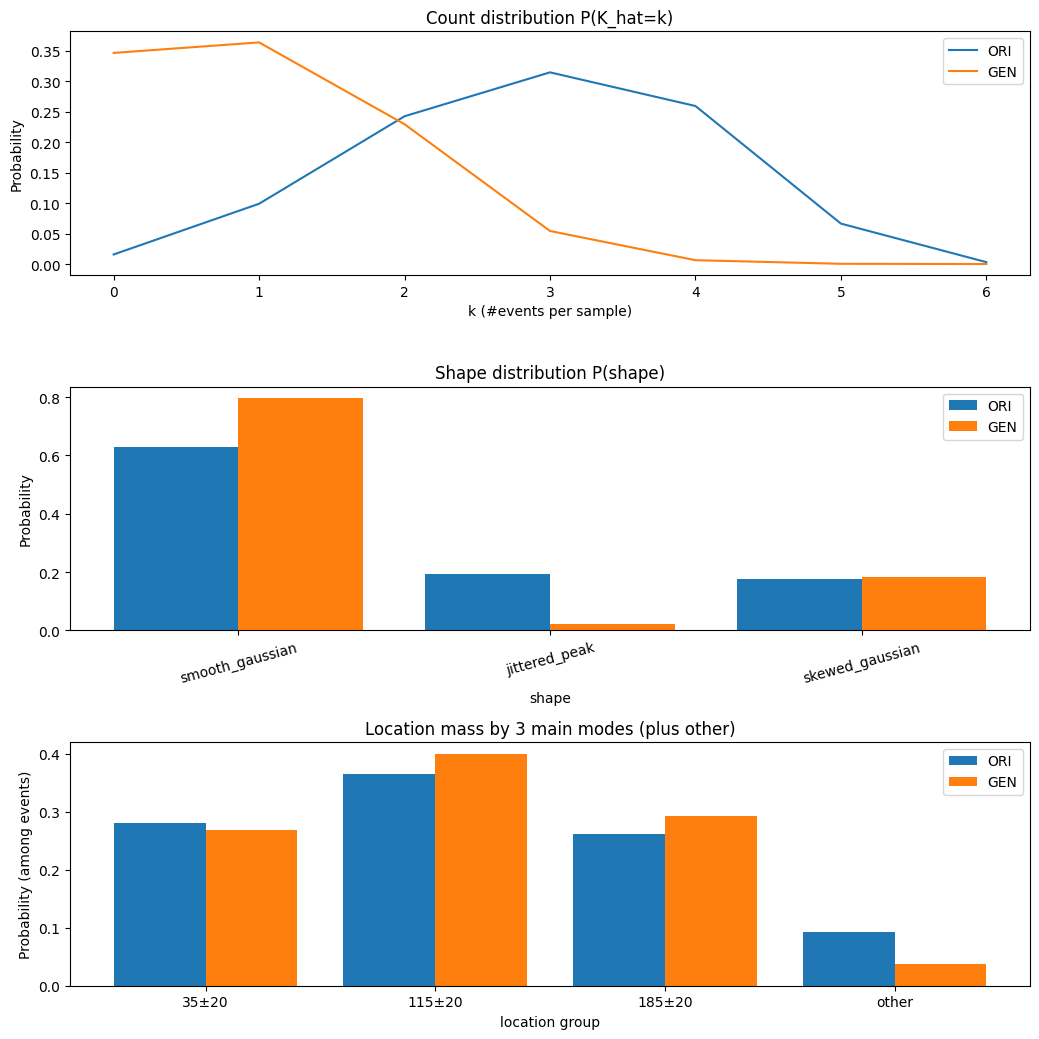

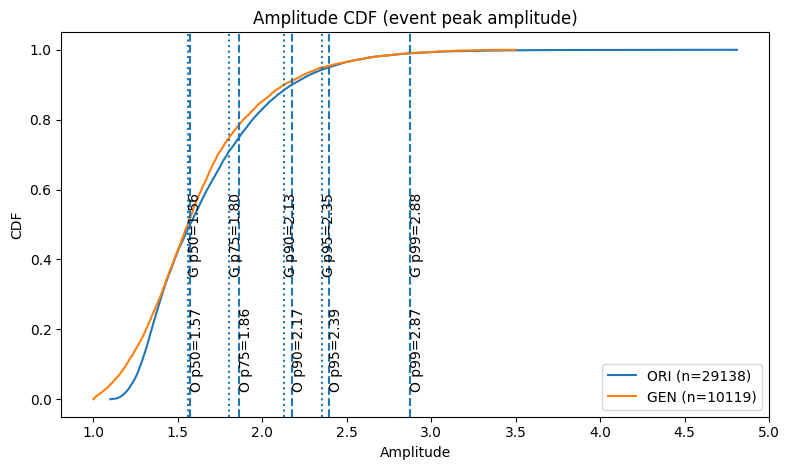

== Amplitude percentiles (ORI vs GEN) ==
p  0: ORI=1.1000 | GEN=1.0001
p  1: ORI=1.1680 | GEN=1.0215
p  5: ORI=1.2346 | GEN=1.1164
p 25: ORI=1.3743 | GEN=1.3565
p 50: ORI=1.5722 | GEN=1.5577
p 75: ORI=1.8626 | GEN=1.8050
p 95: ORI=2.3939 | GEN=2.3531
p 99: ORI=2.8717 | GEN=2.8762
p100: ORI=4.8097 | GEN=3.4996


In [19]:
plot_collapse_dashboard(ori, orievent,
    gen, genevent,
    L=200,
    shape_names=None,
    centers=(35, 115, 185),
    radius=20)

amp_ori = out["ori"]["amp_peaks"]
amp_gen = out["gen"]["amp_peaks"]

plot_amplitude_cdf_compare(amp_ori, amp_gen)